In [73]:
### Datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn import metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# from yellowbrick.cluster import silhouette_visualizer

#Sweetviz EDA
import sweetviz as sv

In [74]:
### Reusable functions

def boxplot_resumen(df, y, columns_list):
    n_varaibles = len(columns_list)
    rows = round((n_varaibles/2)+0.1)
    plt.figure(figsize=(12, 6*rows))
    i = 1
    for idx, plot in enumerate(columns_list):
        ax1 = plt.subplot(rows, 2, i)
        # create a subplot
        sns.boxplot(data=df, x=y, y=plot, ax=ax1)
        # formatting
        ax1.set_title("Distribution for " + plot,)
        i += 1

def histplot_resumen(df, y, columns_list):
    n_varaibles = len(columns_list)
    rows = round((n_varaibles/2)+0.1)
    plt.figure(figsize=(12, 6*rows))
    i = 1
    for idx, plot in enumerate(columns_list):
        ax1 = plt.subplot(rows, 2, i)
        # create a subplot
        sns.histplot(data=df, x=plot, ax=ax1, hue=y, multiple="stack")
        # formatting
        ax1.set_title("Distribution for " + plot,)
        i += 1

# DESCRIPCIÓN DEL PROBLEMA
En el ámbito de los gasoductos, el ROD (rate of drop) se refiere a la velocidad con la que disminuye la presión en un espacio de tiempo determinado, expresado en unidades de psig por minuto. Para salvaguardar los gasoductos, se instalan válvulas automatizadas a lo largo de su infraestructura, y uno de los parámetros clave que se configura en estos dispositivos es el ROD. En esencia, cuando el equipo detecta que este valor se supera, toma automáticamente la decisión de cerrar o seccionar el gasoducto.


El transporte de gas a través de tuberías a alta presión es un proceso caracterizado por cambios lentos en su comportamiento. En condiciones normales de operación, no se anticipan variaciones abruptas en la presión. Generalmente, el ROD puede originarse debido a roturas o fugas, la entrada o salida de equipos compresores, o cambios súbitos en las condiciones de flujo en los puntos de entrada y salida.


Por tanto, es crucial configurar adecuadamente el ROD para garantizar que las protecciones se activen frente a condiciones anómalas de operación, preservando así la seguridad de todas las partes involucradas.
El presente dataset corresponde a valores de ROD máximo y volumen a través de una fuga obtenidos a partir de las combinaciones de las siguientes variables:


* leak_dia: diámetro en pulgadas de una rotura.
* leak_distance: distancia de la rotura hasta el punto de medición del ROD.
* pressure: presión de entrada al escenario en psig.
* flow_pipe: flujo a través de la tubería en Mpcd.

El propósito de este estudio es examinar las relaciones entre las variables previamente descritas y su capacidad para determinar el Rate of Drop (ROD) que se generará. Esta información se utilizará para establecer los valores óptimos de ROD a configurar en las líneas de transporte. El modelo busca responder preguntas específicas, tales como:


* ¿Para una línea operando a una presión y flujo determinado, cuál es el ROD al que se debe configurar la protección para detectar una fuga de un diámetro equivalente en pulgadas? ¿Este ROD configurado corresponde a un flujo que pueda cambiar en condiciones normales de operación, como la entrada o salida de compresores, e incluso cambios en el flujo de las salidas o entradas de gas?


* En caso de una rotura o fuga, ¿a qué ROD equivalente debo configurar la protección si no deseo ventear a la atmósfera una cantidad específica de gas? ¿A qué diámetro equivalente de fuga corresponde este volumen, considerando las condiciones operativas planteadas?
Este estudio pretende proporcionar una comprensión detallada de cómo las variables interrelacionadas afectan el ROD, permitiendo así la determinación precisa de valores óptimos para la configuración de protecciones en las líneas de transporte de gas.


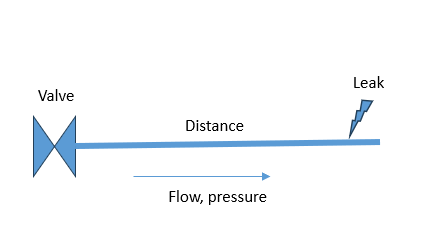

# EDA

In [75]:
rod = pd.read_excel('../data/rod/simulation_results.xlsx')
rod.head()

,ID,leak_dia,leak_distance,pressure,flow_pipe,rod,leak_flow
0,0,3.5,15.3333,1190,76.752,31.966865,152.279497
1,1,3.5,7.6667,653,189.540,17.530478,93.460428
2,2,3.5,7.6667,653,58.729,16.312640,81.364855
3,3,3.5,7.6667,1016,76.752,26.121132,129.525084
4,4,3.5,15.3333,1016,189.540,22.906330,127.163212


Debido a que las variables rod y leak_flow son resultados de las otras, solo se evaluara el problema para hallar el ROD apropiado para la combinaciónd de variables

In [76]:
#rod.drop(columns=['ID','leak_flow'], inplace=True)
#rod_f = rod.drop(columns=['ID','rod'])
#rod_rod = rod.drop(columns=['ID','leak_flow'])
rod_rod = rod.drop(columns=['ID'])
rod.drop(columns=['ID'], inplace=True)
rod_nor = preprocessing.scale(rod_rod)

Text(0.5, 0, 'Número de clusters')

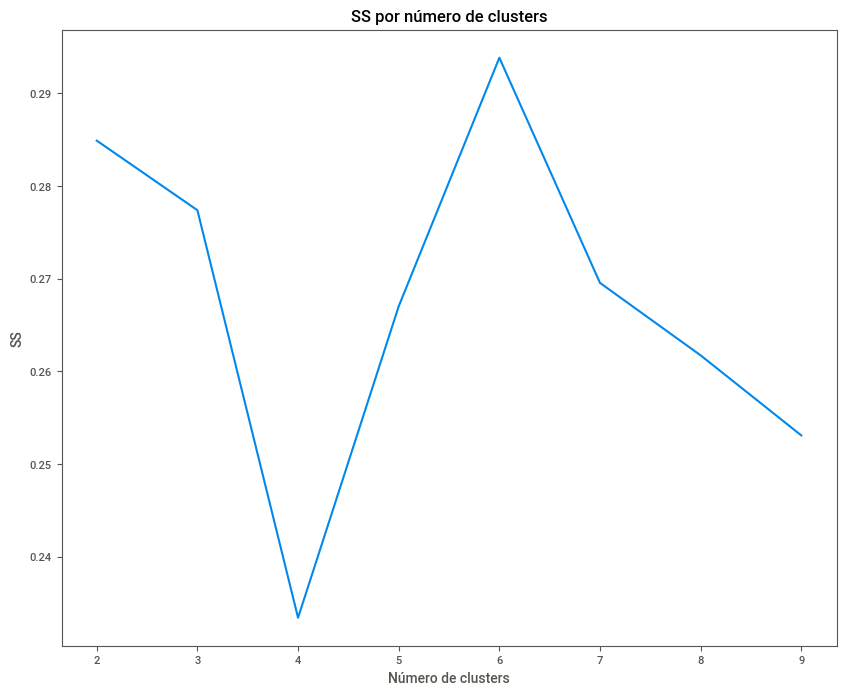

In [77]:
plt.figure(figsize=(10,8))
ss =[]
maxRange = 10
for i in range(2,maxRange):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(rod_nor)
  ss.append(silhouette_score(rod_nor, kmeans.labels_))
plt.plot(range(2,maxRange), ss)
plt.title('SS por número de clusters')
plt.ylabel('SS')
plt.xlabel('Número de clusters')

Text(0.5, 0, 'Número de clusters')

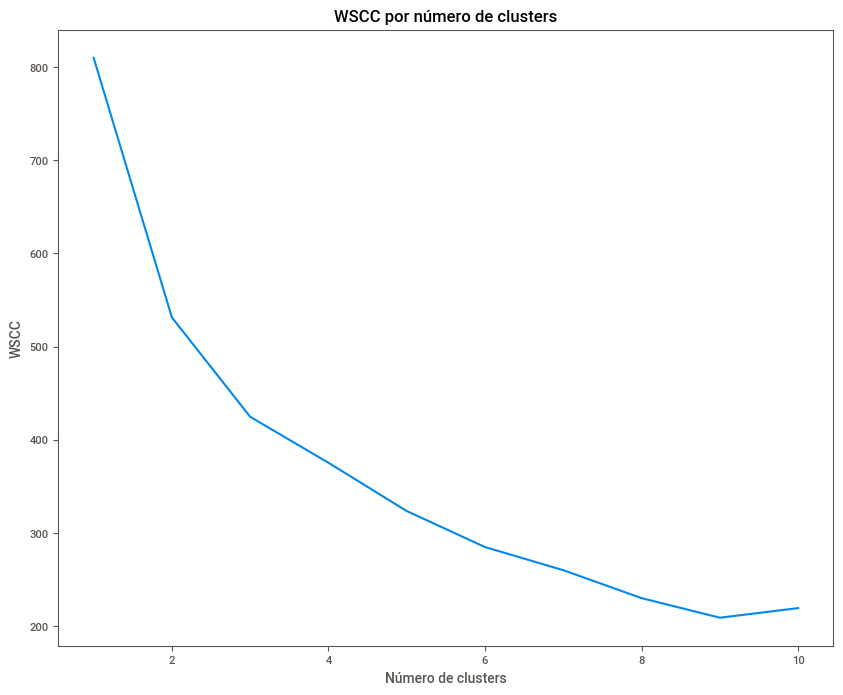

In [78]:
plt.figure(figsize=(10,8))
wscc =[]
maxRange = 11
for i in range(1,maxRange):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(rod_nor)
  wscc.append(kmeans.inertia_)

plt.plot(range(1,maxRange), wscc)
plt.title('WSCC por número de clusters')
plt.ylabel('WSCC')
plt.xlabel('Número de clusters')

In [107]:
#Escojo un modelo de 2 cluster por tener el mayor ss
kmeans = KMeans(n_clusters=2, init='k-means++')
model = kmeans.fit(rod_nor)

#Guardo los clusters en el rdb recodificado
rod['Cluster'] = model.labels_

<Axes: >

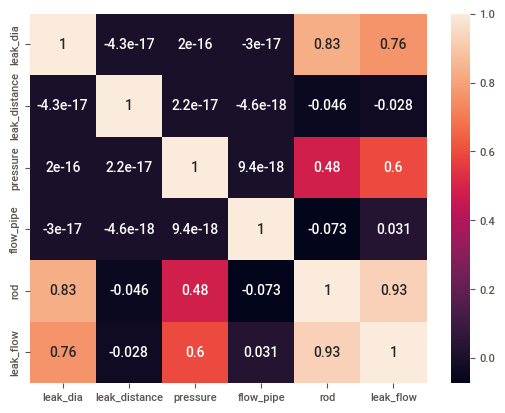

In [121]:
sns.heatmap(rod.drop(columns=['Cluster']).corr(), annot=True)

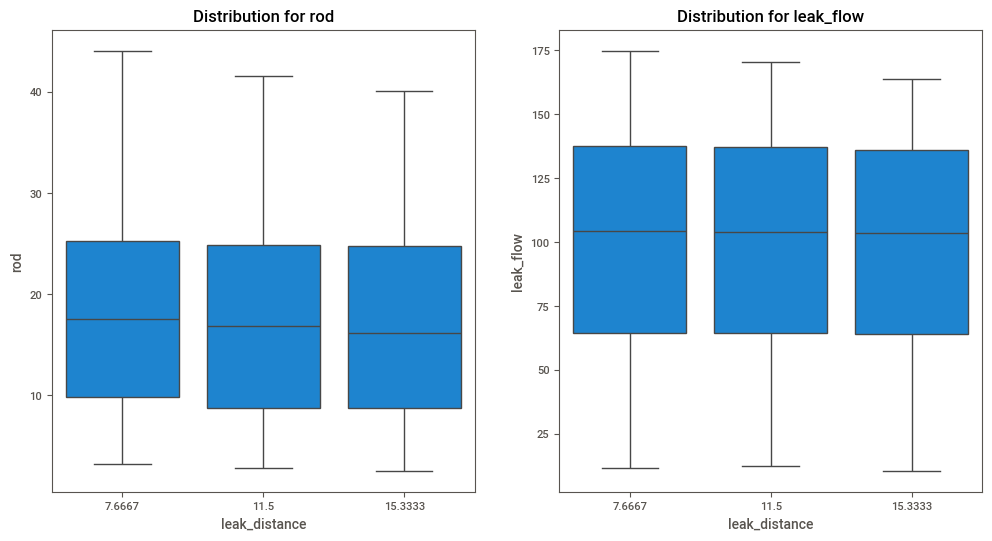

In [108]:
var = [ 'rod','leak_flow']
boxplot_resumen(rod, 'leak_distance', var)

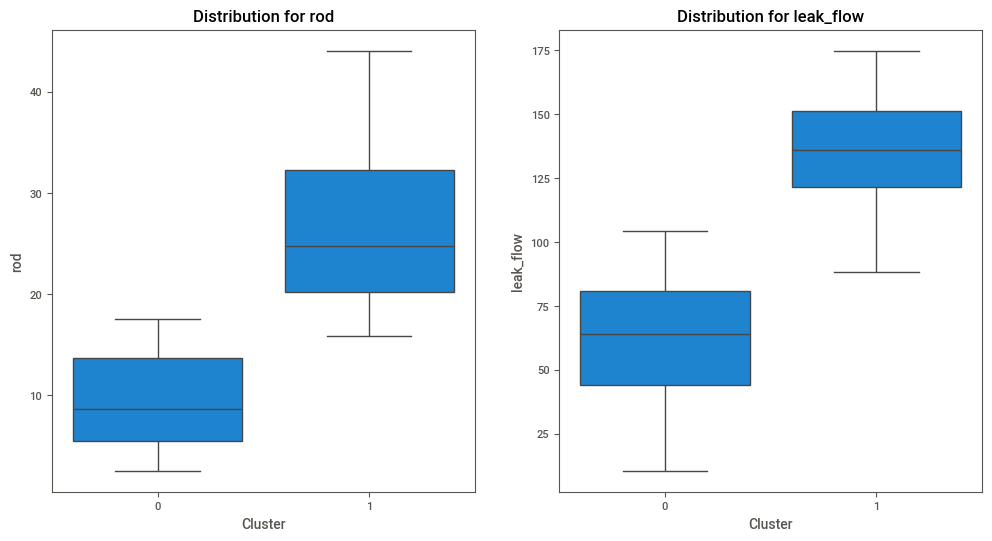

In [109]:
var = [ 'rod','leak_flow']
boxplot_resumen(rod, 'Cluster', var)

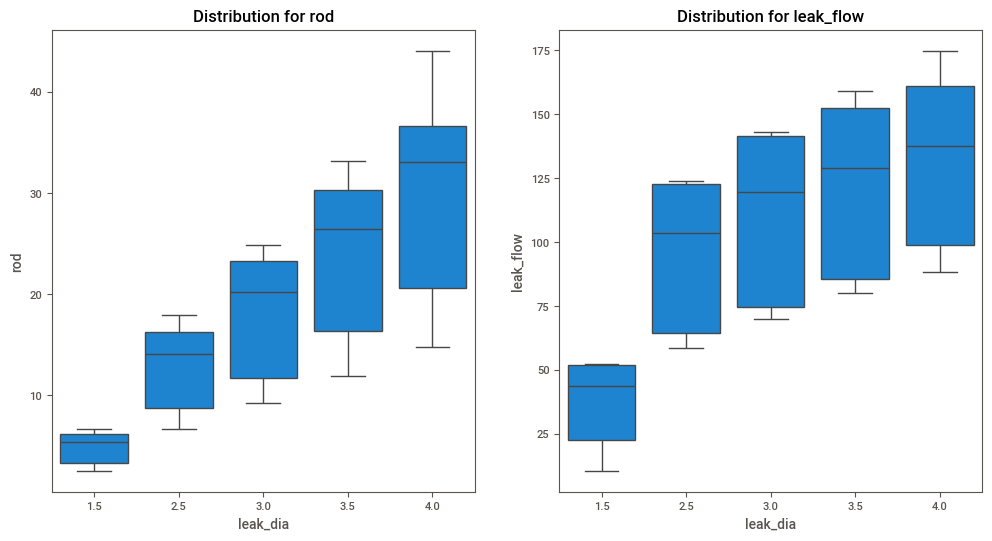

In [110]:
var = [ 'rod','leak_flow']
boxplot_resumen(rod, 'leak_dia', var)

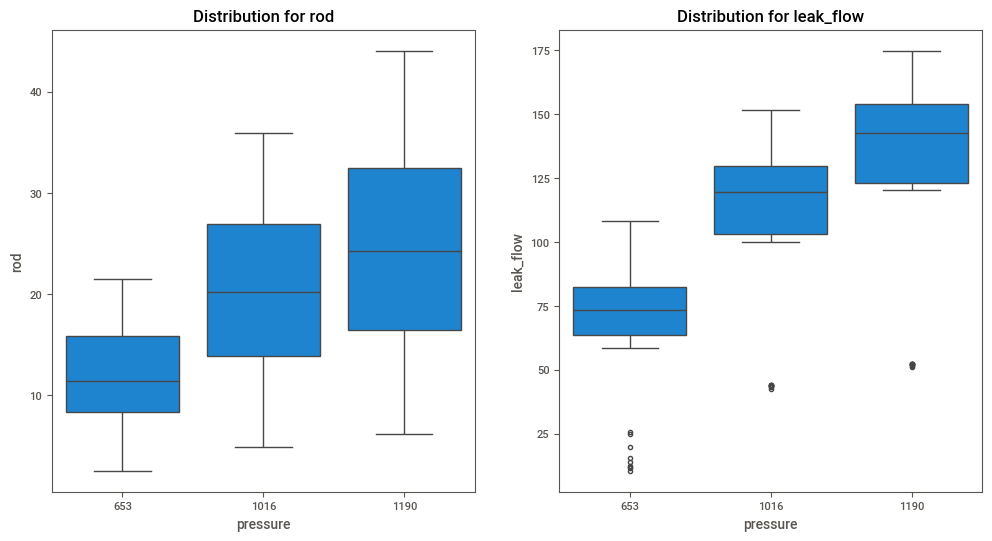

In [111]:
var = [ 'rod','leak_flow']
boxplot_resumen(rod, 'pressure', var)

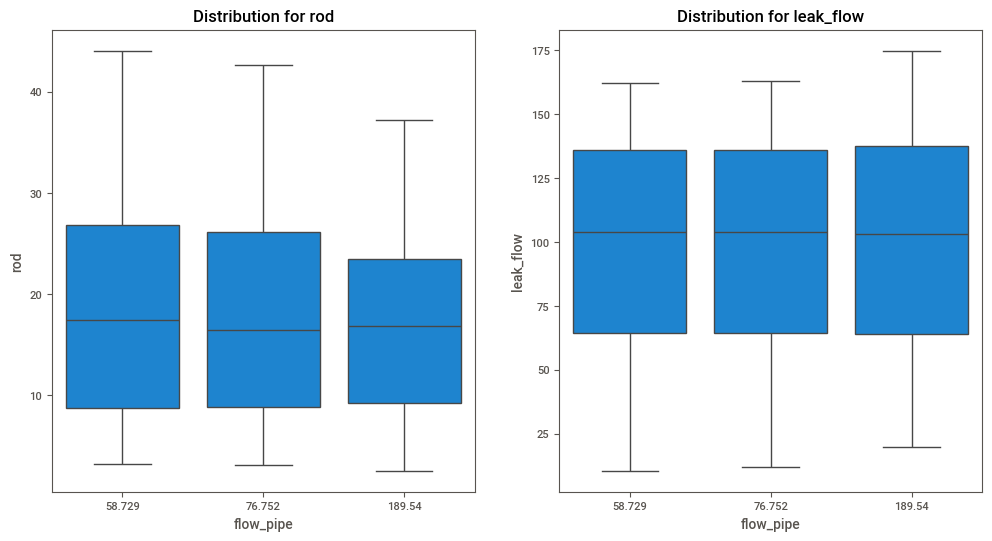

In [112]:
var = [ 'rod','leak_flow']
boxplot_resumen(rod, 'flow_pipe', var)

In [113]:
report = sv.analyze(rod,target_feat='rod')
#report.show_notebook()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


In [115]:
rod.groupby(['Cluster']).describe()['rod']

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,64.0,9.225605,4.333341,2.558591,5.521943,8.649848,13.712796,17.530478
1,71.0,26.338160,7.500817,15.885361,20.181039,24.740066,32.264969,44.053772


In [116]:
px.scatter(rod,y='leak_flow', x='rod', color='Cluster', hover_data='leak_distance')

In [120]:
plt.figure(figsize=(5,10))
fig = px.scatter_3d(rod, x='rod', y='leak_flow', z='pressure',
              color='Cluster')
fig.show()

<Figure size 500x1000 with 0 Axes>

### EDA INSIGHTS

* El dataset está compuesto por 135 observaciones.
* Se encuentran fuertes correlaciones lineales entre el rod generado y las variables leak_dia y pressure. Esto es esperado según lo demostrado por la experiencia de operación. Esto demostraría que estás variables son fundamentales a la hora de explicar el cálculo del ROD.
* El ROD y el flujo a través de la fuga (leak_flow) tienen correlación lineal de 0.93, es decir, a mayor ROD generado en una tubería, mayor será el volumen equivalente.

Al realizar el análisis individual de cada variable con respecto al ROD, se evidencia lo siguiente:


* Flow_pipe: no se evidencia correlación lineal con el ROD. Se evidencia que independiente del valor de flujo, el rango de ROD generado es muy parecido, ni siquiera presenta diferencias en sus valores máximos y mínimos.
* Pressure: se evidencia que a mayor valor de presión, mayor ROD. 
* Leak_dia: se evidencia que a mayor tamaño del diámetro de la fuga, se aumenta el ROD.
* Leak_distance: no se evidencia correlación lineal con el ROD. Se evidencia que independiente de su valor, el rango de ROD generado es muy parecido, ni siquiera presenta diferencias en sus valores máximos y mínimos.
* Entre las variables predictoras no existen relaciones de linealidad fuertes.


Se utilizó clustering en 2 grupos para analizar la información, se encontró que los grupos son divididos de acuerdo con el valor del ROD generado. En terminos generales, el valor divisorio es 17 psig aproximadamente. 

